<h1><center>PUC MG - Pontifícia Universidade Católica de Minas Gerais</center></h1>

<h2><center>Pós-Graduação em Ciência de Dados e Big Data</center></h2>

<h3><center>TRABALHO DE CONCLUSÃO DE CURSO</center>



<h3><center>ALUNO: Diego Francisco Wanch</h3></center>

<br>
<h3><center>TÍTULO: PREVISÃO DE VALORES DE ATIVOS FINANCEIROS ATRAVÉS DO MODELO ARIMA</h3></center>

<br>

In [1]:
#importação dsa bibliotecas

import pandas as pd
import numpy as np
import os
import time
import warnings
from yahooquery import Ticker
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm
from pmdarima.arima.utils import ndiffs


In [2]:
#Ajustes iniciais
%matplotlib inline
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',FutureWarning)
warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
plt.style.use(style="seaborn")

<h3>CARREGAMENTO DOS DADOS</h3>

In [3]:
codigosAtivos = ["PETR3.SA","VALE3.SA"]

tickers = Ticker(codigosAtivos)


In [4]:
df = tickers.history(start=datetime.fromisoformat('2016-05-29'),end=datetime.fromisoformat('2021-05-29'))

In [5]:
dfPetr = df.loc["PETR3.SA"]
dfVale = df.loc["VALE3.SA"]

<p>As ações analisadas são: Petrobras (PETR3) e Vale (VALE3). Sendo utilizado o modelo de previsão ARIMA.</p>
<p>Para os modelos de previsão, os dados de treinamento são os primeiros 80% do período e o restante será utilizado como dados de teste.</p>

### Análise Exploratória da PETR3

In [6]:
dfPetr.shape

(1242, 7)

In [7]:
dfVale.shape

(1242, 7)

In [8]:
dfPetr.isna().sum().sum()


0

In [9]:
dfVale.isna().sum().sum()

0

<AxesSubplot:>

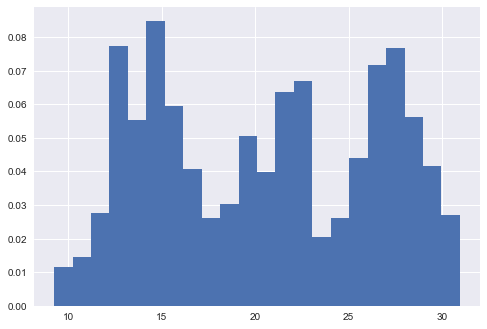

In [10]:
dfPetr['adjclose'].hist(density=True,bins=22)


<AxesSubplot:ylabel='valor de fechamento ajustado'>

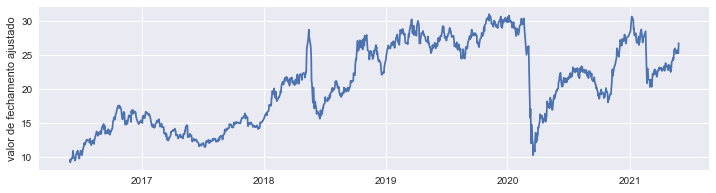

In [11]:
dfPetr.plot.line(y='adjclose',ylabel='valor de fechamento ajustado',xlabel='',legend=False,figsize=(12,3))

In [12]:
dfPetr.describe()


,volume,high,low,close,open,adjclose,dividends
count,1.242000e+03,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000
mean,1.369218e+07,22.513100,21.817802,22.149742,22.172246,20.534694,0.001813
std,1.211639e+07,6.292885,6.184992,6.237774,6.241597,5.920912,0.026918
min,0.000000e+00,10.520000,9.950000,10.180000,10.150000,9.231545,0.000000
25%,7.129800e+06,16.742500,16.290001,16.522501,16.500000,15.010325,0.000000
50%,1.042335e+07,22.639999,21.850000,22.185000,22.175000,20.902271,0.000000
75%,1.599010e+07,28.777501,28.037501,28.345000,28.407500,26.296287,0.000000
max,1.374106e+08,33.700001,32.779999,33.450001,33.000000,30.959145,0.792834


In [13]:
dfPetr = dfPetr['adjclose']

In [14]:
dfPetr.describe()

count    1242.000000
mean       20.534694
std         5.920912
min         9.231545
25%        15.010325
50%        20.902271
75%        26.296287
max        30.959145
Name: adjclose, dtype: float64

### Análise Exploratória da VALE3

<AxesSubplot:>

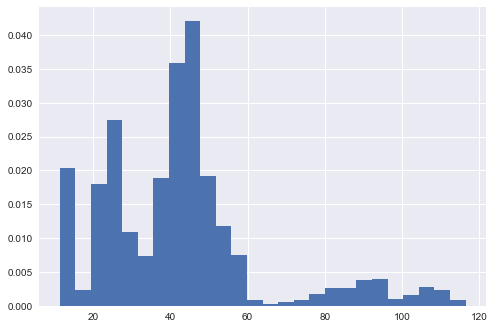

In [15]:
dfVale['adjclose'].hist(density=True,bins=26)

<AxesSubplot:ylabel='valor de fechamento ajustado'>

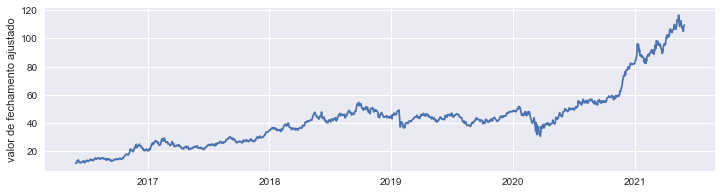

In [16]:
dfVale.plot.line(y='adjclose',ylabel='valor de fechamento ajustado',xlabel='',legend=False,figsize=(12,3))

In [17]:
dfVale.describe()


,volume,high,low,close,open,adjclose,dividends
count,1.242000e+03,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000,1242.000000
mean,1.888175e+07,48.563977,47.215547,47.902923,47.909436,42.489896,0.009295
std,1.364109e+07,21.100676,20.591272,20.879991,20.861077,21.007523,0.153669
min,0.000000e+00,14.470000,13.800000,14.220000,14.070000,11.414804,0.000000
25%,9.713175e+06,32.935000,32.014998,32.532499,32.412499,26.833738,0.000000
50%,1.722095e+07,48.570002,47.490000,47.975000,48.014999,41.865593,0.000000
75%,2.494670e+07,54.980000,53.575002,54.330002,54.200001,48.058794,0.000000
max,1.835345e+08,120.449997,114.690002,118.720001,119.800003,116.420914,4.261646


In [18]:
dfVale = dfVale['adjclose']

In [19]:
dfVale.describe()

count    1242.000000
mean       42.489896
std        21.007523
min        11.414804
25%        26.833738
50%        41.865593
75%        48.058794
max       116.420914
Name: adjclose, dtype: float64

# Modelos Preditivos

## Introdução

### Estacionariedade

O primeiro passo é verificar a estacionariedade. 


#### Teste ADF

O teste ADF (Augumented Dickey Fuller) mostra se a série de preços é estacionária.

A hipótese nula é que a série temporal não é estacionária. Então, se o p-value for menor que o nível de significância (adotaremos 0.05), rejeitamos a hipótese nula e concluímos que a série é estacionária.

Caso não seja, realizamos sucessivas diferenciações, até que encontremos uma que seja estacionária. O número de passos será o parâmetro Integrativo do modelo ARIMA (d).


### Parâmetro da parcela Autorregressiva (p)
 O parâmetro AutoRegressivo p é a quantidades de períodos anteriores (lag) que é significativa para inluenciar o valor atual.


### Parâmetro da parcela Média Móvel (q)
 O parâmetro da Média Móvel (q) é o lag que é significativo para a média móvel dos desvios.

# Determinação dos parâmetros do modelo para PETR3

In [20]:
n = int(len(dfPetr) * 0.8)
trainPetr = dfPetr[:n]
testPetr = dfPetr[n:]


## Verifica se é estacionária

In [21]:
# Check if price series is stationary
result = adfuller(trainPetr.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -2.21118444738926
p-value: 0.20221121963060762


Valor p maior que 0.05 nos mostra que 
# Não

Então, diferenciar uma vez e repetir o teste.


In [22]:
diff = trainPetr.diff().dropna()


In [23]:
result = adfuller(diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -7.7341375704339965
p-value: 1.1051767927400695e-11


Valor p maior que 0.05 nos mostra que é.
### Portanto, parãmetro d para a PETR3 é 1.

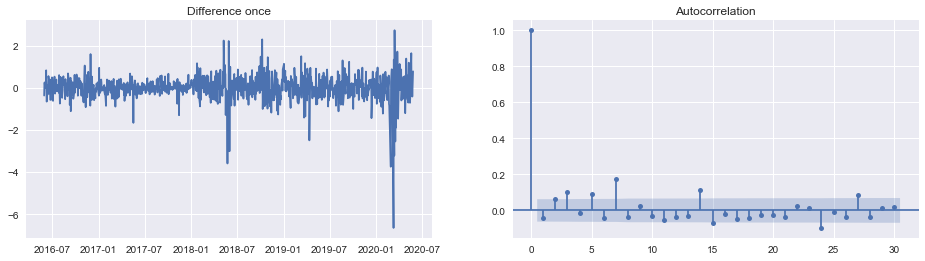

In [24]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))


ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2)
plt.show()

### O pacote pmdarima tem um método que calcula o grau ideal de diferenciação automaticamente.
#### Será usado como "Prova Real"


In [25]:
ndiffs(trainPetr, test="adf")

1

Resultado coindiciu.

#### ACF (Autocorrelation Function) e PACF (Partial Autocorrelation Function) para obter os parâmetros p e q

p é o tamanho do lag, o quanto no passado o modelo vai "olhar" para calcular sua parcela Autorregressiva.

q é o tamanho do lag para a parcela do modelo que considera a Média Móvel dos erros.

In [1]:
diff = trainPetr.diff().dropna()
plot_pacf(diff)
plt.show()




NameError: name 'trainPetr' is not defined

In [ ]:
plot_acf(diff)
plt.show()

#### no PACF, o último "lollipop"  fora do intervalo de confiança antes de começarem a cair dentro do intevalo é o 3
então, p = 3

#### no ACF,  também temos no índice 3 o último "lollipop" fora do intervalo de confiança antes de começarem a cair dentro do intevalo.
portanto, q = 3

# Determinação dos parâmetros do modelo para VALE3

In [27]:
n = int(len(dfVale) * 0.8)
trainVale = dfVale[:n]
testVale = dfVale[n:]


## Verifica se é estacionária

In [28]:
# Check if price series is stationary
result = adfuller(trainVale.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.713130540576923
p-value: 0.42436024126217037


Valor p maior que 0.05 nos mostra que não

Então, diferenciar uma vez e repetir o teste.


In [29]:
diff = trainVale.diff().dropna()


In [30]:
result = adfuller(diff.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -12.220863579352892
p-value: 1.1081335780744387e-22


Valor p maior que 0.05 nos mostra que é.
### Portanto, parãmetro d para a VALE3 é 1.

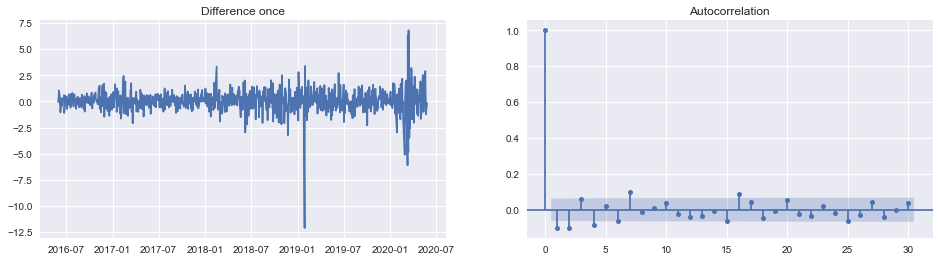

In [31]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))


ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2)
plt.show()

### O pacote pmdarima tem um método que calcula o grau ideal de diferenciação automaticamente.
#### Será usado como "Prova Real"


In [32]:
ndiffs(trainVale, test="adf")

1

Resultado coindiciu.

#### ACF (Autocorrelation Function) e PACF (Partial Autocorrelation Function) para obter os parâmetros p e q

p é o tamanho do lag, o quanto no passado o modelo vai "olhar" para calcular sua parcela Autorregressiva.

q é o tamanho do lag para a parcela do modelo que considera a Média Móvel dos erros.

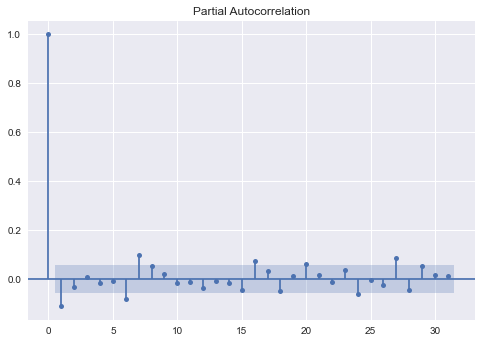

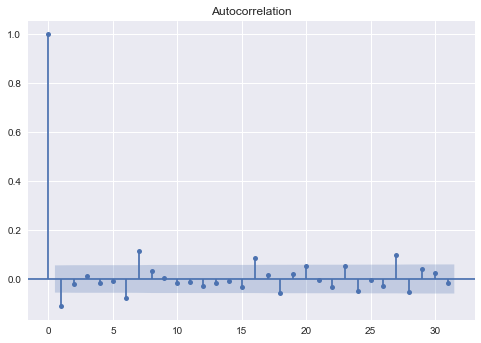

In [33]:
diff = dfVale.diff().dropna()
plot_pacf(diff)
plt.show()
plot_acf(diff)
plt.show()



#### no PACF, o último "lollipop"  fora do intervalo de confiança antes de começarem a cair dentro do intevalo é o 1
então, p = 1

#### no ACF,  também temos no índice 1 o último "lollipop" fora do intervalo de confiança antes de começarem a cair dentro do intevalo.
portanto, q = 1

## Aplicando o modelo ARIMA(3,1,3) sobre os dados da PETR3

In [41]:
modelPetr = ARIMA(trainPetr, order=(3, 1, 3))
result = modelPetr.fit()

D:\anaconda\ANACONDA\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\ANACONDA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency informa

### Resultado do fit

In [35]:
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.adjclose   No. Observations:                  992
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -875.293
Method:                       css-mle   S.D. of innovations              0.585
Date:                Sat, 31 Jul 2021   AIC                           1766.587
Time:                        13:36:28   BIC                           1805.785
Sample:                             1   HQIC                          1781.491
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0102      0.024      0.428      0.669      -0.037       0.057
ar.L1.D.adjclose    -0.9204      0.083    -11.123      0.000      -1.083      -0.758
ar.L2.D.adjclose     0.5700 

# Aplicando o modelo ARIMA(1,1,1) sobre os dados da VALE3

In [36]:
modelVale = ARIMA(dfVale, order=(1, 1, 1))
result = modelVale.fit()

D:\anaconda\ANACONDA\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\anaconda\ANACONDA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency informa

### Resultado do fit

In [37]:
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.adjclose   No. Observations:                 1241
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1937.990
Method:                       css-mle   S.D. of innovations              1.153
Date:                Sat, 31 Jul 2021   AIC                           3883.981
Time:                        13:36:28   BIC                           3904.475
Sample:                             1   HQIC                          3891.688
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0789      0.028      2.787      0.005       0.023       0.134
ar.L1.D.adjclose     0.1534      0.244      0.628      0.530      -0.326       0.632
ma.L1.D.adjclose    -0.2684 

Resultado mostra que o termo AR e o termo MA não são significativos

## Utilizar o método auto_arima(...) em busca de parâmetros melhores para o modelo

In [38]:
#Definição do modelo
modelVale = pm.auto_arima(trainVale, start_p=1, start_q=1,
                      test='adf',       # usa o adftest para encontrar o melhor valor 'd'
                      max_p=5, max_q=5, # Máximo 'p' e 'q'
                      d=1,                      # Frequência da série
                      stationary = False, #Estacionaridade
                      seasonal=False, #Sazonalidade
                      start_P=0, 
                      D=1, 
                      trace=True, #Se TRUE, mostra a lista de modelos ARIMA considerados.
                      error_action='ignore',  
                      suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2820.457, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2835.519, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2827.303, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2824.728, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2834.642, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2803.386, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2816.889, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2805.215, Time=0.43 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2804.955, Time=0.68 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2802.965, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2816.766, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2804.962, Time=0.96 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2815.989, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2801.076, Time=1.29 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

In [40]:
#Treinamento do modelo
result = modelVale.fit(trainVale)
#Exibição do resultado
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  993
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -1387.264
Date:                Sat, 31 Jul 2021   AIC                           2794.529
Time:                        13:41:34   BIC                           2843.526
Sample:                             0   HQIC                          2813.158
                                - 993                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0118      0.076     -0.155      0.877      -0.161       0.138
ar.L2          1.1749      0.079     14.900      0.000       1.020       1.329
ar.L3         -0.2130      0.046     -4.638      0.0

# Análise PETR3

In [44]:
result = modelPetr.fit()

D:\anaconda\ANACONDA\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [ ]:
residuals = pd.DataFrame(result.resid)


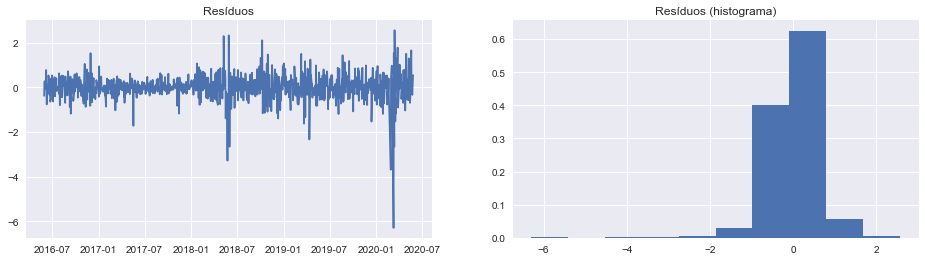

In [46]:
# resíduos e histograma dos resíduos

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)
ax1.set_title("Resíduos")
ax2.hist(residuals, density=True)
ax2.set_title("Resíduos (histograma)")
plt.show()

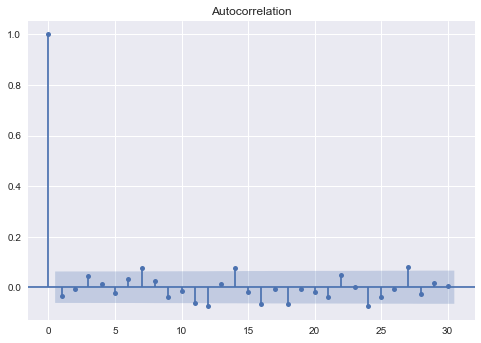

In [47]:
# ACF dos resíduos. Idealmente, tudo deveria ficar dentro da margem de erro.
# isso significaria que o modelo "sugou" tudo que tinha de previsível e sobrou só ruído branco
plot_acf(residuals)
plt.show()

In [49]:
#prever para o período de teste
step = len(testPetr)
# Forecast
fc, se, conf = result.forecast(step)

In [50]:
pred = result.predict(typ='levels')

In [53]:
fc = pred.append(pd.Series(fc, index=testPetr[:step].index))
lower = pd.Series(conf[:, 0], index=testPetr[:step].index)
upper = pd.Series(conf[:, 1], index=testPetr[:step].index)

In [57]:
actual = trainPetr.append(testPetr[:step])


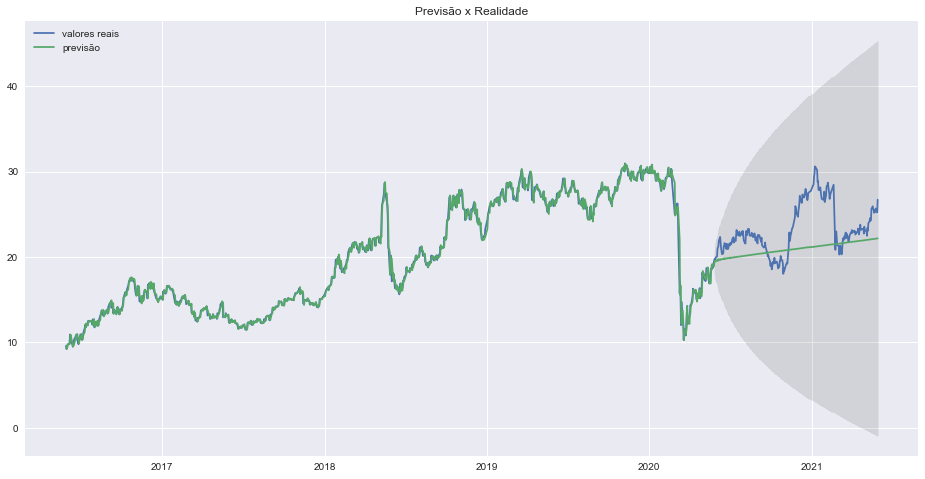

In [60]:
plt.figure(figsize=(16, 8))

plt.plot(actual.index, actual.values, label="valores reais")
plt.plot(fc, label="previsão")
plt.fill_between(lower.index, lower, upper, color="k", alpha=0.1)
plt.title("Previsão x Realidade")
plt.legend(loc="upper left")
plt.show()

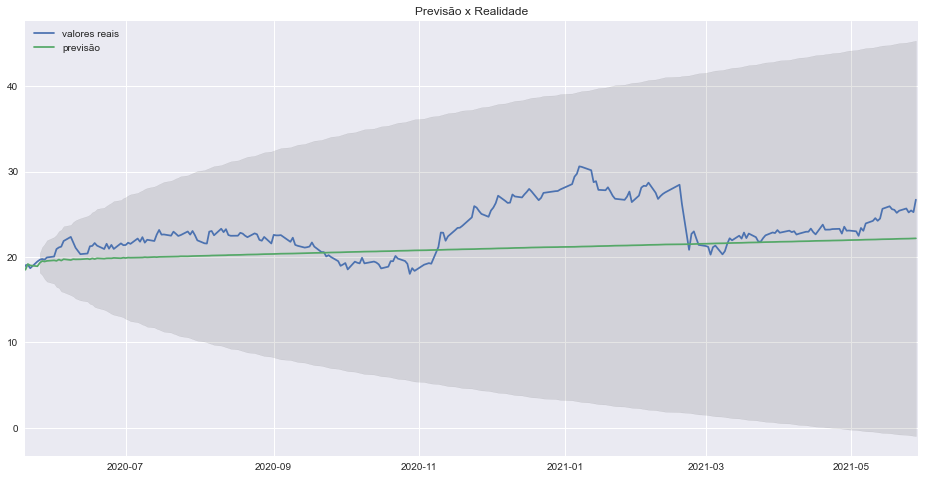

In [61]:
##Zoom para facilitar a visualização
plt.figure(figsize=(16, 8))

plt.plot(actual.index, actual.values, label="valores reais")
plt.plot(fc, label="previsão")
plt.fill_between(lower.index, lower, upper, color="k", alpha=0.1)
plt.title("Previsão x Realidade")
plt.legend(loc="upper left")
plt.xlim("2020-05-20","2021-05-29")

plt.show()

# Análise VALE3

In [64]:
#Faz a predição 
forecast_arima = modelVale.predict(n_periods=len(testVale))
forecast_arima = pd.DataFrame(forecast_arima, index = testVale.index,columns=['Prediction'])
conf_int = modelVale.predict(len(testVale), return_conf_int=True, alpha = 0.05) #Pega o intervalo de confiança

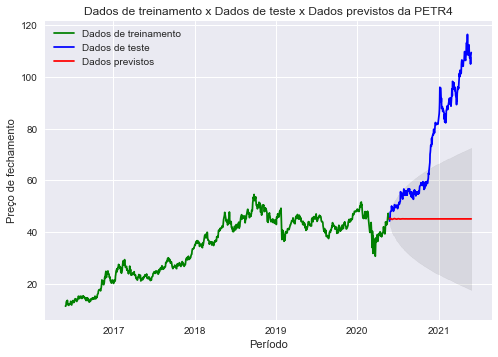

In [65]:
plt.title('Dados de treinamento x Dados de teste x Dados previstos da PETR4')
plt.plot(trainVale, color='green', label = 'Dados de treinamento')
plt.plot(testVale, color = 'blue', label = 'Dados de teste')
plt.fill_between(testVale.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
plt.show()

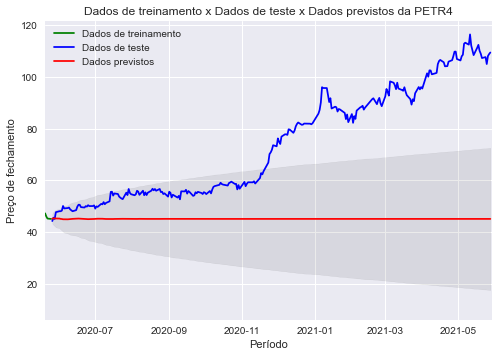

In [66]:
plt.title('Dados de treinamento x Dados de teste x Dados previstos da PETR4')
plt.plot(trainVale, color='green', label = 'Dados de treinamento')
plt.plot(testVale, color = 'blue', label = 'Dados de teste')
plt.fill_between(testVale.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
plt.xlim("2020-05-20","2021-05-29")
plt.show()
